In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 1.1.dev320+g92a6eb9f4 
Supposed to be 1.0 (21-12-2022)


In [2]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.maps import MapAxis
from gammapy.modeling.models.spectral import scale_plot_flux
from gammapy.estimators import  FluxPointsEstimator
    
from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
from Dataset_Creation import sys_dataset

## Read dataset

spatial binsize =  [0.08] deg
MapDataset
----------

  Name                            : 4282ubWh 

  Total counts                    : 388209 
  Total background counts         : 360331.31
  Total excess counts             : 27877.69

  Predicted counts                : 361333.07
  Predicted background counts     : 360331.34
  Predicted excess counts         : 1001.73

  Exposure min                    : 2.07e-01 m2 s
  Exposure max                    : 2.41e+11 m2 s

  Number of total bins            : 540000 
  Number of fit bins              : 180191 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -924522.99

  Number of models                : 2 
  Number of parameters            : 11
  Number of free parameters       : 7

  Component 0: SkyModel
  
    Name                      : Source
    Datasets names            : None
    Spectral model type       : PowerLawSpectralModel
    Spatial  model type       : GaussianSpatialModel
    Temporal model ty

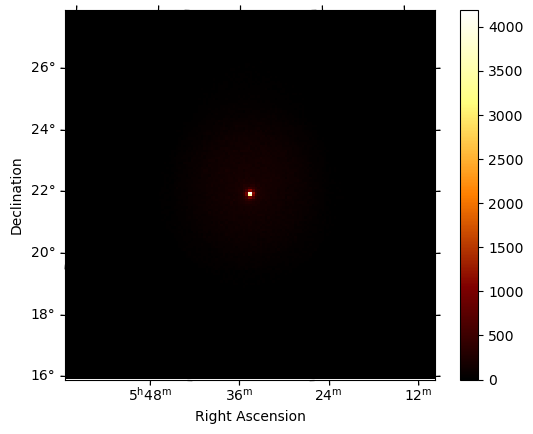

In [3]:
source = 'Crab'
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
path_crab = '/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/nuisance_summary/Crab'


dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
dataset_standard = dataset_standard.downsample(4)
models = Models.read(f"{path_crab}/standard_model.yml")
model_spectrum  = PowerLawSpectralModel(
    index=2.3,
    amplitude="1e-12 TeV-1 cm-2 s-1",    )
source_model = SkyModel(spatial_model = models['main source'].spatial_model ,
                       spectral_model = model_spectrum,
                       name = "Source")    
models = Models(source_model)

bkg_model = FoVBackgroundModel(dataset_name=dataset_standard.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_standard.models = models

dataset_asimov = dataset_standard.copy()
dataset_asimov.counts = dataset_standard.npred()
models = Models(source_model.copy())
bkg_model = FoVBackgroundModel(dataset_name=dataset_asimov.name)
bkg_model.parameters['tilt'].frozen  = False
models.append(bkg_model)
dataset_asimov.models = models

    
dataset_standard.counts.sum_over_axes().plot(add_cbar=1)
binsize = dataset_standard.geoms["geom"].width[1] / dataset_standard.geoms["geom"].data_shape[1]
print(
    "spatial binsize = ",
    binsize
)

print(dataset_standard)

## Varying the Exposure

In [10]:
shift = +0.1
tilt = 0.015


N = 100
sigma_a = shift
sigma_i = tilt

save = True
save_flux = True




In [11]:
for n in range(N):
    try:
        print(n)
        shift_rnd = np.random.normal(0, shift, 1)
        tilt_rnd = np.random.normal(0, tilt, 1)
        print(f"shift:, {shift_rnd}, tilt: {tilt_rnd}" )
        sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = shift_rnd, 
                        tilt = tilt_rnd,
                        rnd = True)
        dataset = sys_d_cor.create_dataset()
        fit_cor = Fit(store_trace=False)
        result_cor = fit_cor.run([dataset])


        if save:
            with open("data/7a_P_draw_info.txt", "a") as myfile:
                myfile.write(str(float(shift_rnd)) + '    '+ str(float(tilt_rnd)) + '    ' +  str(float(dataset.stat_sum())) + '\n')

        stri = ""
        for p in ['amplitude', 'index', 'norm', 'tilt']:
            stri += str(dataset.models.parameters[p].value)  + '   ' +  str(dataset.models.parameters[p].error)  + '   '
        print(stri)
        if save:
            with open("data/7a_P_draw_par.txt", "a") as myfile:
                myfile.write(stri + '\n')


        mask = dataset.mask.data[:,60,60]

        ebins = dataset.counts.geom.axes[0].center[mask]
        fluxes = []
        for e in ebins:
            flux =  dataset.models[0].spectral_model(e)
            fluxes.append(flux.value)

        ff = str()
        for f in fluxes:
            ff += str(f) + "  "
        #print(ff)
        if save:
            with open("data/7a_P_draw_flux.txt", "a") as myfile:
                myfile.write( ff + '\n')


        energy_bounds = (ebins[0], ebins[-1] ) * u.TeV

        energy_min, energy_max = energy_bounds
        energy = MapAxis.from_energy_bounds(
            energy_min,
            energy_max,
            18,
        )

        fluxe2, _ = dataset.models[0].spectral_model._get_plot_flux(sed_type='dnde', energy=energy)
        fluxe2 = scale_plot_flux(fluxe2, energy_power=2)
        fluxe2 = fluxe2.quantity[:, 0, 0]
        fluxe2 = np.array(fluxe2)   
        ff = str()
        for f in fluxe2:
            ff += str(f) + "  "
        if save:
            with open("data/7a_P_draw_flux2e.txt", "a") as myfile:
                myfile.write( ff + '\n')

        energy_edges = dataset.geoms['geom'].axes[0].edges
        esti  = FluxPointsEstimator(energy_edges= energy_edges)
        fluxpoints = esti.run([dataset])
        if save_flux:
            fluxpoints.write(f'data/fluxpoints/6_fluxpoints_{shift_rnd[0]:.6}.fits')
    except:
        pass


0
shift:, [-0.02521479], tilt: [-0.01365976]
1.0020913688906179e-12   9.511745107384608e-14   2.4338600745537606   0.07457165476473905   1.00193482425244   0.002068414651029814   0.0002157319839433931   0.0019599566756858555   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.9743412896870941 1.0030175882806305
norm 1.2280249269760293 0.4098033397397436
norm 0.9507797666285349 0.20912479556621202
norm 1.0973125603041551 0.18884297632259853
norm 0.8201537965130977 0.18730795035085376
norm 0.9967327066164869 0.20294898670764236
norm 1.1373451151816056 0.22807006913918915
norm 0.9154525674914766 0.24257677383641296
norm 1.0932106167769597 0.2803283907838875
norm 1.0322922570277053 0.32723989096774475
norm 0.5231489201892949 0.3277826373263063
norm 1.3201218811616409 0.44007407647372015
norm 0.9000411194969918 0.4597887352798465
norm 1.1244511162542372 0.5555763379824754
norm 0.5963033679887967 0.6176284275489354
norm 1.6031604973271483 0.869263500588647
norm 2.185802370795564

norm 1.1404714887991718 0.2592799489026508
norm 1.4992515818207546 0.31306601221163133
norm 0.7907958818323222 0.27950557049854874
norm 1.0739857847920644 0.3617402778892297
norm 1.0231134510300288 0.3802748057725994
norm 0.1367604098294756 0.31896293677494575
norm 0.8111473232965116 0.44732161558485495
norm 1.2478868418574276 0.6092635617169508
norm 0.11672175351571218 0.3627651834302368
norm 1.0 0
8
shift:, [0.06211956], tilt: [-0.02177258]
8.242245120570831e-13   7.897569528820562e-14   2.2580519794419156   0.06139898479145057   0.9989349628193204   0.0020636707191561254   -0.0012232920890080854   0.0019597948351597564   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.6322249854056564 1.208677749759289
norm 1.4317030794975532 0.5001248947260707
norm 0.87994217200635 0.23205680347775362
norm 1.0275889812746943 0.1973417904940936
norm 0.7495143811973177 0.18843937890709983
norm 0.7023669702417734 0.18743117216340405
norm 1.2843852963426772 0.22345974656499384
norm 1.446

norm 1.8645493016376182 1.2051553449559524
norm 0.4124384228324417 0.4278507286248849
norm 0.830648603737603 0.22252276161615656
norm 0.9916416851492433 0.18583447489427612
norm 1.3651303143002347 0.19483293704051108
norm 1.080669994893523 0.1984215926615946
norm 0.9399759336668594 0.19741729597017002
norm 0.996896120916083 0.21961940943552058
norm 0.7280826331662711 0.2205473824408189
norm 0.9767287507849748 0.24679473189574666
norm 0.4640785622491131 0.23402223491204033
norm 1.2410793987445237 0.33952663103071
norm 0.9964979549037379 0.346263582785567
norm 2.0350322276920885 0.4978964393390901
norm 0.5486705549290167 0.35908719834621067
norm 1.1699376813066436 0.5240726408722691
norm 0.8121947872845728 0.5081150222054318
norm 0.939285070536614 0.636945496722476
norm 1.0 0
16
shift:, [-0.01970418], tilt: [0.02043476]
7.89097799977089e-13   8.72323103734372e-14   2.2931910574220185   0.07447596351847711   0.9991771080461846   0.002064620617208461   0.0007320823864143038   0.00196241959

norm 2.2024549518956684 0.9424878130190965
norm 0.11748778716088415 0.47714750677545364
norm 1.0 0
23
shift:, [-0.06218192], tilt: [-0.00743169]
1.2297324772641752e-12   1.1099608674196269e-13   2.2943647137402694   0.056649647044572995   1.000309409627363   0.002069716520286366   0.001134063261338713   0.0019643106951287093   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.4148802482180516 1.0296255950528237
norm 1.6352265116935412 0.39779103898468676
norm 0.9327165637312517 0.18890304326476343
norm 1.106234177925874 0.16691825538155186
norm 0.8187004283826259 0.15790534133878112
norm 0.8087535805012708 0.16643691641999633
norm 0.9395790552483794 0.181584124298722
norm 0.9237955961557279 0.19328939182356109
norm 1.3683848627565176 0.23472823676652957
norm 0.9573526447251209 0.23183524625361787
norm 1.366743216756936 0.2833788734636173
norm 0.9719965992483213 0.2895404881640074
norm 0.6671514312836622 0.3107033952126537
norm 1.1575627046201478 0.38979107329629736
norm 1.

norm 1.159764814865743 0.24451056384811148
norm 1.1044235697432117 0.26187956581004135
norm 0.9426852214991993 0.2736341366785577
norm 0.7518270393445078 0.30225021862559226
norm 1.0215348576563312 0.34422528094545046
norm 0.5108379761471602 0.3436490572671885
norm 1.6779261054001386 0.5353717608525995
norm 0.9206664954319937 0.5326723584014926
norm -0.11381050625974927 0.3013634643627668
norm 1.0616836248384836 0.6678020700153754
norm 1.9559397077679335 1.033367000254058
norm 1.0 0
31
shift:, [-0.07414441], tilt: [-0.00481408]
1.206706887422216e-12   1.0052001149725108e-13   2.3407762541074537   0.05924808268867253   1.0012421095614905   0.0020672779817181965   -0.0014172521772795998   0.0019577834522580303   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.3816241209199684 0.7952454925045256
norm 1.7088057101673813 0.39870986108886136
norm 1.0129190624968434 0.19016469553096144
norm 0.8066707089421293 0.1579795974342324
norm 1.2017676194206723 0.17191911727394235
norm 

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/gammapy/gammapy/modeling/models/spatial.py:555: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


7.737625838932165e-13   6.977072227403165e-14   2.2342734850181785   0.05903200863732635   0.9996567251516844   0.002064685497086409   -0.0027330523549466733   0.0019569679912069876   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm -0.18319578093202757 1.0555190792710039
norm 1.5104647766122006 0.45367165798326275
norm 0.916179025459263 0.21169395984570194
norm 0.9711622366990568 0.18164984454083086
norm 0.9366159671611861 0.18231095026615005
norm 0.9246392574348733 0.18288225522719068
norm 1.093342712149336 0.20210910958092873
norm 1.24581411997333 0.22237824255334818
norm 0.9799976413413487 0.22115677026648195
norm 0.8675018964231548 0.2339935093262815
norm 0.8749524482889316 0.2693536807572756
norm 1.1482906457378137 0.3303252962672606
norm 1.1596531623972348 0.35955019774522506
norm 1.3441505955919781 0.4360288141237428
norm 0.13370438582396663 0.28121030324507235
norm 0.8828816377420917 0.49396283334068036
norm 1.615920790153147 0.687735155707374
norm 0.69649774064305

norm 0.9721895400925813 0.2847178140515842
norm 0.7578868327066084 0.2909336744514703
norm 1.2484051379676553 0.38501068828950985
norm 0.9087009234957827 0.38234465831600384
norm 1.018245155842952 0.4555575370487794
norm 1.4153159697305764 0.5711418459806388
norm 0.3663830322814083 0.3816429130916784
norm 1.7993765156096218 0.9077928897760736
norm 1.0 0
45
shift:, [0.11903869], tilt: [-0.00148509]
9.752417744297824e-13   9.905934901826197e-14   2.392709721828848   0.07123938271899947   1.001124513014772   0.0020718418533136125   -0.0014528728857111347   0.001960029097502547   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.9295336106528498 1.0108124392970443
norm 1.473791584484174 0.40406631243377256
norm 0.9561217434618497 0.2020807589792401
norm 1.0075709572066227 0.17684658231375883
norm 0.9084524797869499 0.18043114354634593
norm 0.9840059085852475 0.19312731940144687
norm 0.8922593313526537 0.2073685264847262
norm 1.1764051895214664 0.24307268501211174
norm 0.919957

/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: overflow encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/hpc/caph/mppi045h/anaconda3/envs/gammapy-2.0-dev/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


1.0171785716591228e-12   9.270866777594601e-14   2.3414107684856384   0.06578424051532625   0.999442148491059   0.002065631920651202   -0.0006180800421722776   0.0019610172589019097   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.24040950023968694 0.9283335387718588
norm 1.2688370762321581 0.408282767889725
norm 1.1328722688073702 0.20909944802345212
norm 1.1039975333098395 0.18347814517409133
norm 0.960957043123212 0.18041128412593901
norm 0.7655927531008979 0.18089455303763546
norm 0.7248199278863401 0.19293238607749794
norm 1.2487873099234261 0.22991872482378187
norm 1.2058859452143742 0.2592506010941872
norm 0.8363493168949676 0.26139444204386
norm 0.7729965095526105 0.3029235092409643
norm 1.4152595856690569 0.3756004685395994
norm 0.9248174725674613 0.3823166854333524
norm 0.5179658545222453 0.3760054032630808
norm 1.114710308377995 0.5979690924572557
norm 1.7686220922707274 0.6994836427413713
norm 0.012880937433232952 0.3998225156939704
norm 2.20315266986858 1.1

norm 0.7489296221311726 0.27605772504994275
norm 0.5358510746385732 0.28684899846699463
norm 0.8846608658720082 0.37316068953615006
norm 0.9206516421013643 0.4194169238206057
norm 1.2663247337926125 0.5368330029710849
norm 0.9954123262433608 0.5787357420499428
norm 1.240768009894722 0.7438600849355675
norm 2.4216153103795794 1.0635574308035771
norm 1.0 0
59
shift:, [-0.17604656], tilt: [0.01465263]
1.189564024292729e-12   1.1311729531456922e-13   2.2463121671581976   0.05980898797414201   1.0006682908463407   0.002067794138160279   0.0014865312926868647   0.001963175928483707   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.83913564055088 1.2654626863470169
norm 0.8083593570404666 0.41226828224407325
norm 1.0999722003222878 0.2195677998649443
norm 0.8846022163165125 0.1810518405449661
norm 1.0646467355982967 0.18499199859284546
norm 0.6994966026031565 0.1752707194107668
norm 1.2206025248608006 0.2059879742820984
norm 1.1739811277107495 0.22452070250645573
norm 0.9879371

norm 0.771230196843007 0.33036512678883556
norm 1.0703865172169007 0.1891829680558724
norm 1.123050661131482 0.1657280146850835
norm 1.1210559531153468 0.17736386707642118
norm 0.6814233770811378 0.16977946900319377
norm 0.995853718806279 0.19931759051378933
norm 1.2158128898233886 0.22937995395754507
norm 0.8887663596689693 0.23696480505696998
norm 0.6991931882633824 0.25411721342648275
norm 0.5096825921045348 0.27343351866237964
norm 1.2243180174658224 0.3898741310932727
norm 1.8151274632259031 0.5039231174863157
norm 1.6663984374915424 0.5754443490769856
norm 0.5098320473316081 0.43835514321241587
norm 1.042222213733808 0.6279452950572613
norm 0.5668543687791538 0.6966308473219447
norm 1.6295946880069683 1.1748775474381956
norm 1.0 0
67
shift:, [0.18290413], tilt: [-0.00010104]
8.807289968455081e-13   7.391678705696621e-14   2.241254903138331   0.05507186729640026   1.0010227506781675   0.0009505776096855438   5.231639451270268e-05   0.0009015579919716288   
norm 1.0 0
norm 1.0 0
no

norm 1.1749787756731713 0.7046267042418306
norm 1.0 0
74
shift:, [0.046884], tilt: [-0.00021781]
8.622688826997508e-13   8.443123149754217e-14   2.218813528565395   0.06347405778734713   0.9972349030320139   0.0020725555388216564   -0.0023430072888711703   0.0021043253730535123   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.5924756546482896 1.2449760692129592
norm 0.8605565713742316 0.45975886382042686
norm 0.9063264993972424 0.22967936138249095
norm 0.8298806596123477 0.1882930529366186
norm 1.1679777168148946 0.1953209659794709
norm 1.110268538510354 0.19624351976598814
norm 0.880788904189351 0.19648463925662177
norm 0.9950315005762259 0.225074068290946
norm 0.933273667735293 0.22953711323845577
norm 1.403355544165641 0.27399892642259094
norm 1.0412466516130372 0.2805855788991612
norm 0.8079045753208695 0.29655062158593476
norm 1.4613083197289407 0.38524365856189163
norm 1.2631730352410608 0.43239517559471075
norm 0.3574659108375154 0.3131595829352561
norm 0.1721385

norm 1.3834483091277123 0.23913223851885607
norm 1.1565394432051563 0.251335073806164
norm 1.132193851394738 0.29516480073095536
norm 1.144415084675767 0.34353950852093496
norm 0.9335052026248603 0.3453103800384455
norm 0.1761491486747145 0.3117924006535322
norm 1.016267154567507 0.47185982437463575
norm 0.7891370984827912 0.5117949722313739
norm -0.26039160766978137 0.07292368845581804
norm 1.140002245532893 0.8459285209987727
norm 1.0 0
82
shift:, [0.0604693], tilt: [-0.01139077]
8.827096468315845e-13   9.065627282541474e-14   2.2398665633627957   0.0612974008604527   0.9974138746824293   0.002064992965644733   -8.802721655980517e-05   0.0019652802856040693   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 2.0850950586274837 1.2339039900565854
norm 1.0550229387559389 0.46209495149702995
norm 0.8677684183090966 0.22455591489524607
norm 0.9863398170041665 0.18996896900508572
norm 1.1958351272006826 0.19563881845107667
norm 0.9439486547583826 0.19045988831908614
norm 1.0867

norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.14542255569956086 1.0337430121470712
norm 0.931565909359574 0.42545294211229867
norm 1.200307525982249 0.22249692759062867
norm 0.6355808952153993 0.17686001802507
norm 1.0746952283485394 0.18743709102643627
norm 1.1187320087512278 0.19514466841108496
norm 0.9398905058348805 0.1988079482107011
norm 1.1090396655064947 0.2260944563428887
norm 1.1843811010987166 0.25381029640854563
norm 1.1804515976662908 0.27050428356406714
norm 0.6311657325085929 0.2761933019996072
norm 0.8760693633444174 0.3099977476011102
norm 1.440171731194569 0.41995445439019613
norm 1.0622623089755858 0.4075600428621637
norm 0.741220753432009 0.4140374127100359
norm 0.1947398362037451 0.38793353839141287
norm 1.1411921701293593 0.6000531659959855
norm 1.0612630313705373 0.7444261074791325
norm 1.0 0
90
shift:, [-0.01229255], tilt: [-0.03517747]
9.916584050751856e-13   8.960760531212316e-14   2.2543579304679136   0.05666325061799008   1.0000795223379648   0.00206608

norm 1.0212394001162786 0.5898487371765323
norm 1.2961720891860522 0.748415426861589
norm -0.3478407448743958 0.1024548713647553
norm 1.0 0
97
shift:, [-0.18863329], tilt: [-0.01442108]
1.2416394293916212e-12   1.1138386819934496e-13   2.336934781162516   0.0627488764633188   1.0011588573422372   0.002066975355014856   -0.0010823791441871668   0.001958187611627167   
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 1.0 0
norm 0.7885267780219303 1.000292525972416
norm 0.9314146608308893 0.3872420136773743
norm 1.1547579965369248 0.21082337366996187
norm 1.0464699712038594 0.17685222801455427
norm 0.7140740531713653 0.16974538643069434
norm 1.1670206607874547 0.19271885984042111
norm 0.9780890920926075 0.19810035731762876
norm 1.107139123513651 0.22381157368295368
norm 1.142353190817015 0.24216414124576166
norm 0.6727267297888272 0.23675494499056188
norm 1.0444951078852183 0.3116989080492369
norm 0.7230871652703036 0.29128885810455657
norm 1.3778384441031983 0.43019442002458735
norm 0.99